# Homework Assignment 3 - Chem 277B
## Breast Cancer Prediction

### 1) Objective

We found in the last HW assignment that many features of the Breast Cancer Wisconsin dataset are highly correlated.
Analyze the Breast Cancer Wisconsin dataset using dimensionality reduction and classification techniques (Naive Bayes) to predict whether a tumor is benign or malignant. Compare the results to your earlier findings.

### 2) Preparation

Before starting, import the necessary libraries for data analysis and visualization. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

Load the dataset from `sklearn`, which contains cell descriptors and a target variable (diagnosis: 0 = malignant, 1 = benign).

In [2]:
data, target = load_breast_cancer(return_X_y=True, as_frame=True)
feature_names = data.columns

Split the dataset into training (50%) and testing (50%) sets this time. Use `random_state=42` for reproducibility. Scale the features to a range of [0, 1] using `MinMaxScaler`.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.50, random_state=42)

######## Fill in the code below ########

# scale train and test data
scaler   = MinMaxScaler(feature_range = (0, 1)) 
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# build a map to avoid converting back to DataFrame
column_map = {name: idx for idx, name in enumerate(X_train.columns)}

########################################

print(f'Shape of training features: {X_train.shape}')
print(f'Shape of training labels: {y_train.shape}')
print(f'Shape of test features: {X_test.shape}')
print(f'Shape of test labels: {y_test.shape}')

Shape of training features: (284, 30)
Shape of training labels: (284,)
Shape of test features: (285, 30)
Shape of test labels: (285,)


### 3) Baseline results

Use the *mean radius* (the first feature) to build a Gaussian Naive Bayes classifier. Evaluate the classifier on the test set and display the confusion matrix. The results should be not as good as the result from the previous homework assignment due to the reduced training set size.

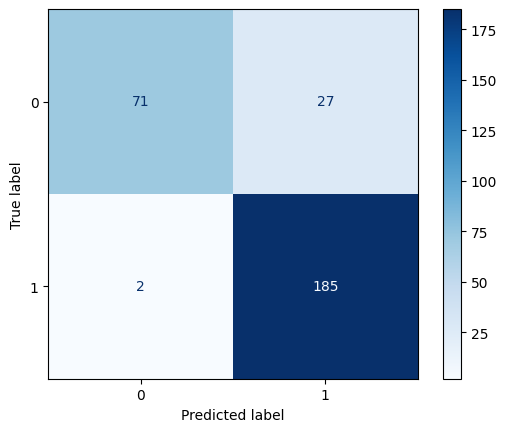

In [4]:
######## Fill in the code below ########

# our target features
features = ["mean radius"]  
indices = [column_map[name] for name in features]

X_train_selected = X_train_scaled[:, indices]
X_test_selected = X_test_scaled[:, indices]

# Chew, chew... I'm a train!
gnb = GaussianNB()
Fit = gnb.fit(X_train_selected, y_train)

# predict our classes
y_pred = Fit.predict(X_test_selected)
proba = Fit.predict_proba(X_test_selected)

########################################

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [5]:
import seaborn as sns

'''
# with 30 features...
# ...this is very slow
out = sns.pairplot(data, kind = "kde", \
                   plot_kws = {'color':[176/255,224/255,230/255]}, \
                   diag_kws = {'color':'black'})
out.map_offdiag(plt.scatter, color = 'black')
plt.show()
''';

### 4) Principal Component Analysis

#### 4.1) PCA on training set

Perform PCA on the **training set** to reduce the dimensionality. Plot the **full** eigenvalue spectrum (use log scale for the y-axis). How many principal components are needed to explain at least 90% of the variance in the data?

In [6]:
#data.columns
#data.mean()
#data.var()

print("We note that our varibles have vastly different variences.")

We note that our varibles have vastly different variences.


Explained variance ratio by the 7 principal components: 0.022507337129825063
Total explained variance by the 7 principal components: 0.910095300696731


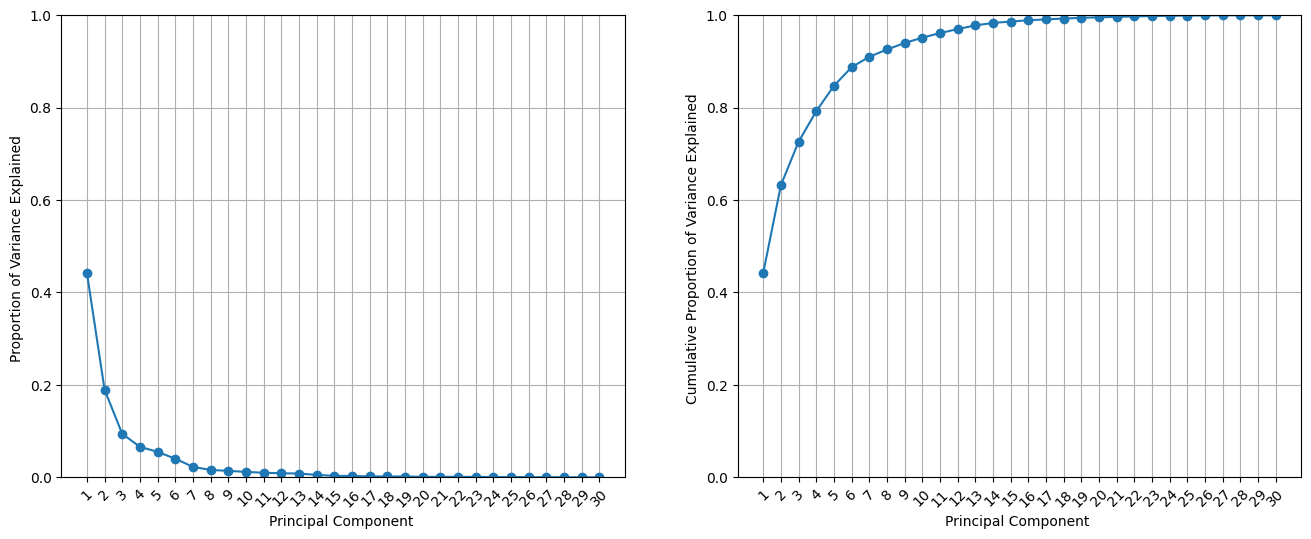

In [7]:
######## Fill in the code below ########
# see also: 12.5 Lab: Unsupervised Learning
# in "An Introduction to Statistical Learning with Applicaitions in Python"
# by Hastie, et al (www.statlearning.com)

from sklearn.preprocessing import StandardScaler

# we use the StandardScaler to apply means and std to our data
scaler = StandardScaler(with_std=True, with_mean=True)

# now we explore positive semi-definite scaling
#scaler = MinMaxScaler(feature_range=(0, 1))

# apply scaler
# data_scaled = scaler.fit_transform(data) # oops that's everything
data_scaled = scaler.fit_transform(data)

# now let's try not scaling (bad idea)
#data_scaled = data

pca = PCA()

pca.fit(data_scaled)
#print(pca.mean_)
scores = pca.transform(data_scaled)
#print(scores)
#print(scores.std(0, ddof =1))
#print(pca.explained_variance_)
#print(pca.explained_variance_ratio_)

fig , axes = plt.subplots (1, 2, figsize =(16, 6))
ticks = np.arange(pca.n_components_) + 1
ax = axes[0]
ax.plot(ticks, pca.explained_variance_ratio_, marker='o')
ax.set_xlabel('Principal Component ');
ax.set_ylabel('Proportion of Variance Explained ')
ax.set_ylim ([0 ,1])
ax.set_xticks(ticks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid()

ax = axes [1]
ax.plot(ticks ,
pca.explained_variance_ratio_.cumsum(), marker='o')
ax.set_xlabel('Principal Component ')
ax.set_ylabel('Cumulative Proportion of Variance Explained ')
ax.set_ylim ([0, 1])
ax.set_xticks(ticks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid()

# collect data for report
variance_ratio = pca.explained_variance_ratio_
cumsum = pca.explained_variance_ratio_.cumsum()

# discover how many PCs we need to excees 90% comulative var
idx = np.argmax(cumsum > 0.90)
n_components90 = idx + 1

# indivual varience explained by n-th PC
ratio = variance_ratio[idx]

# total cumulative var explain by the first n PCs
ratio_tot = cumsum[idx]

########################################

print(f'Explained variance ratio by the {n_components90} principal components: {ratio}') # what are that asking here?
print(f'Total explained variance by the {n_components90} principal components: {ratio_tot}')

#### Discussion 4.1
We tested several scaling methods to explore how they affected the number of principal components needed to explain at least 90% of the variance in our data.

Using **no scaling**, we found that a single principal component captured 98% of the variance. While this may seem efficient, it’s misleading: our features have wildly different units and variances, so PCA disproportionately emphasized one dominant feature while others contributed very little.

With **MinMaxScaler(feature_range=(0, 1))**, 6 principal components were needed to explain 91% of the variance. This method equalizes feature scales while preserving relative spacing, which can be advantageous when features are bounded or when nonlinear relationships matter. It also enforces a positive semi-definite covariance matrix, ensuring all eigenvalues are non-negative and the decomposition remains stable, thus reducing numerical artifacts.

Using **StandardScaler(with_mean=True, with_std=True)**, 7 principal components were required to explain 91% of the variance. StandardScaler centers each feature to zero mean and unit variance, distributing variance equally across dimensions. This reveals the **true correlation structure** of the data rather than just raw magnitude, allowing PCA to uncover latent patterns that are otherwise masked by scale differences.

**In summary**, PCA with StandardScaler gave the best representation of our latent structure. Using this approach, we needed seven principal components to explain at least 90% (0.910095300696731) of the variance in our dataset.  While we believe this is the most mathmatically precise (and correct answer) we acknowlege using the MinMaxScaler has the potential to reduce compute and improve numerical stablity.  

#### 4.2) Analyze PCA

Visualize the principal components. What are the loadings of the original features on PC1? Which features contribute most? Compare the PCA results with the correlation plot from the previous homework assignment.

In [16]:
loadings = pca.components_.T  # shape: (n_features, n_components)
print(loadings.shape)
pc1_loadings = loadings[:, 0]  # first principal component

pc1_loadings

(30, 30)


array([0.21890244, 0.10372458, 0.22753729, 0.22099499, 0.14258969,
       0.23928535, 0.25840048, 0.26085376, 0.13816696, 0.06436335,
       0.20597878, 0.01742803, 0.21132592, 0.20286964, 0.01453145,
       0.17039345, 0.15358979, 0.1834174 , 0.04249842, 0.10256832,
       0.22799663, 0.10446933, 0.23663968, 0.22487053, 0.12795256,
       0.21009588, 0.22876753, 0.25088597, 0.12290456, 0.13178394])

                 Feature  PC1 Loading  Abs Loading
7    mean concave points     0.260854     0.260854
6         mean concavity     0.258400     0.258400
27  worst concave points     0.250886     0.250886
5       mean compactness     0.239285     0.239285
22       worst perimeter     0.236640     0.236640
26       worst concavity     0.228768     0.228768
20          worst radius     0.227997     0.227997
2         mean perimeter     0.227537     0.227537
23            worst area     0.224871     0.224871
3              mean area     0.220995     0.220995


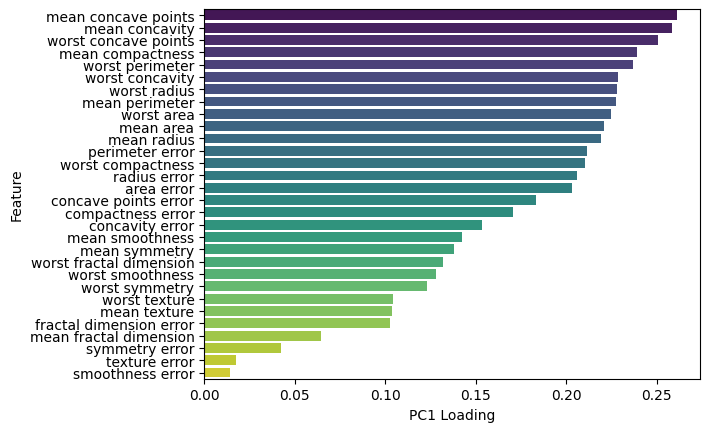

In [18]:
import pandas as pd

feature_names = data.columns  # use all
pc1_df = pd.DataFrame({
    'Feature': feature_names,
    'PC1 Loading': pc1_loadings
})
pc1_df['Abs Loading'] = pc1_df['PC1 Loading'].abs()
pc1_df_sorted = pc1_df.sort_values(by='Abs Loading', ascending=False)
print(pc1_df_sorted.head(10))  # our top 10 contributing features

sns.barplot(
    x='PC1 Loading',
    y='Feature',
    hue='Feature',  # assign hue to make pretty
    data=pc1_df_sorted,
    palette='viridis', # best for male color blindness
);

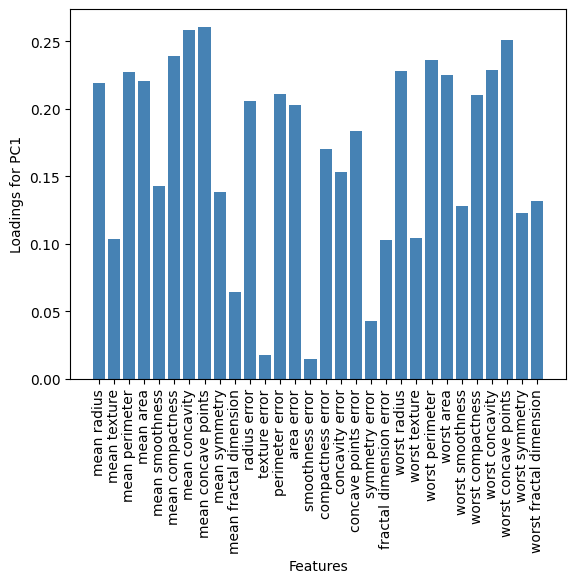

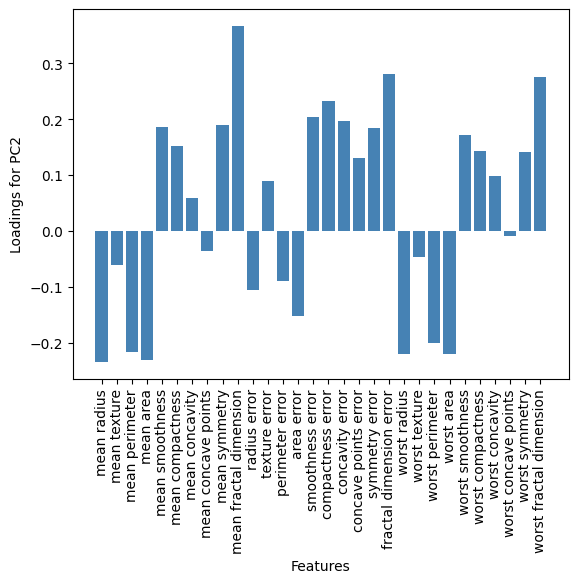

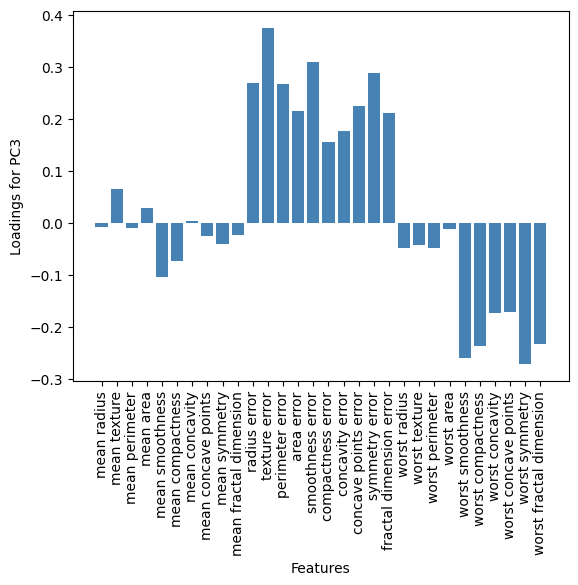

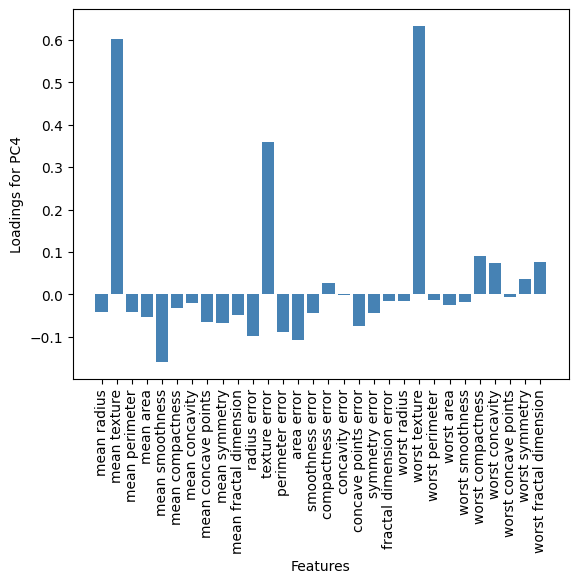

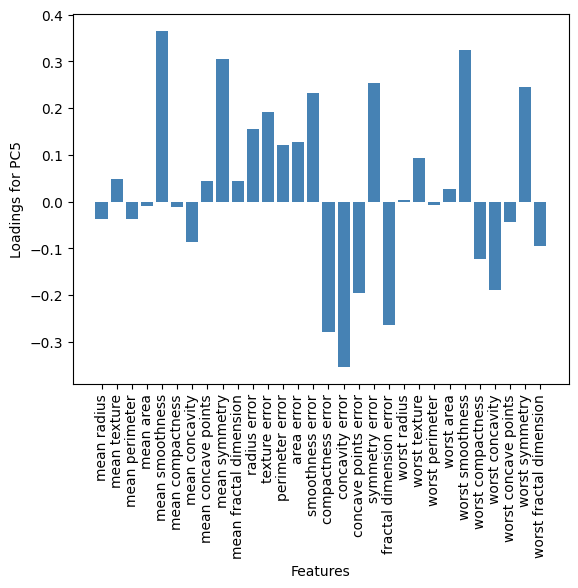

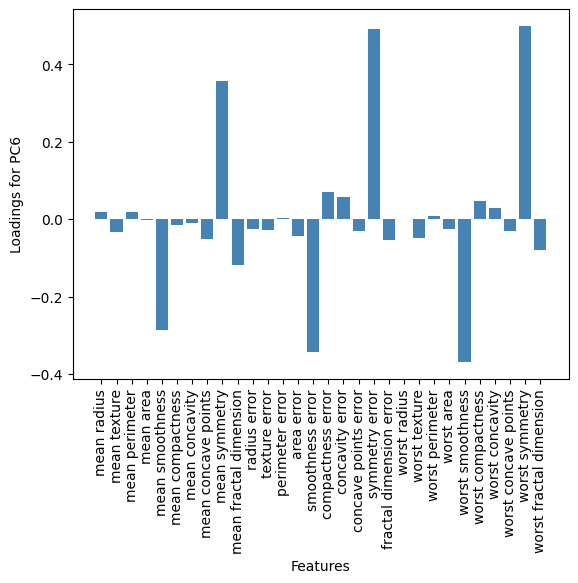

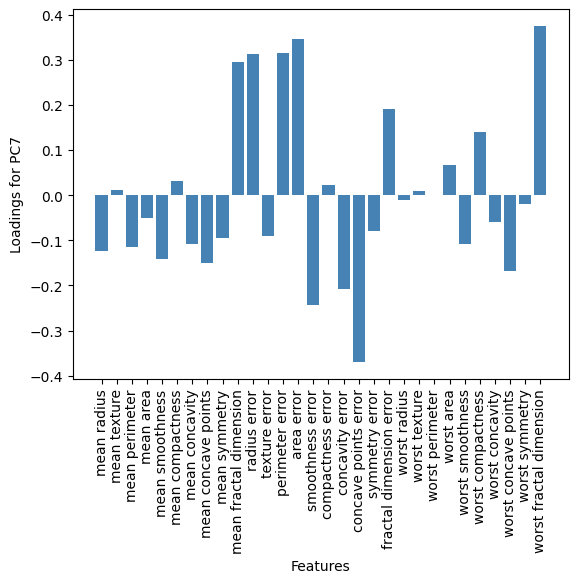

In [15]:
for i in range(n_components90):
    plt.figure()

    ######## Fill in the code below ########
    # Honestly, this starter code doesn't align well
    #   with the problem statement.
    # This visualization isn't particularly insightful, 
    #   but we'll roll with it.
    # We'll plot the loadings for the first n principal components.
    pc_loadings = pca.components_.T[:, i]
    plt.bar(data.columns , pc_loadings, color='steelblue')
    
    ########################################

    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel(f'Loadings for PC{i+1}')
    plt.show()

#### Discussion 4.2

Honestly, the starter code doesn't align well with the problem statement.
We created our our visualization based on the actual problem statement then adapted it to the starter code.

*What are the loadings of the original features on PC1?*
```
                 Feature  PC1 Loading  Abs Loading
7    mean concave points     0.260854     0.260854
6         mean concavity     0.258400     0.258400
27  worst concave points     0.250886     0.250886
5       mean compactness     0.239285     0.239285
22       worst perimeter     0.236640     0.236640
26       worst concavity     0.228768     0.228768
20          worst radius     0.227997     0.227997
2         mean perimeter     0.227537     0.227537
23            worst area     0.224871     0.224871
3              mean area     0.220995     0.220995
```
These loadings represent the weights of each original feature in the first principal component.
Features with larger absolute loadings contribute more to PC1.
In our case, shape descriptors (concavity, compactness, concave points) dominate, followed closely by geometric features (perimeter, radius, area).


*Which features contribute most?*

The strongest contributors to PC1 where:

 - mean concave points
 - mean concavity
 - worst concave points
 - mean compactness

These features appear to describe the shape complexity of the tumor.

*Compare the PCA results with the correlation plot from the previous homework assignment.*

From HW_02, we observed strong correlations among geometric features:
```
mean radius      mean perimeter     0.997855
worst radius     worst perimeter    0.993708
mean radius      mean area          0.987357
mean perimeter   mean area          0.986507
worst radius     worst area         0.984015
...
```

Also recall in HW_2 we found a strong correlation within feature catorgories such as geometric features, error terms, shape descriptors, and statistical metrics.
These reflected inherent geometric relationships: radius, perimeter, and area scale together.
We also saw clustering among shape descriptors like compactness, concavity, and concave points.

PCA confirms this structure, where PC1 is driven by shape descriptors, which are tightly correlated.
Geometric features (radius, perimeter, area) also contributed, but to a lesser extent.
Thus correlation matrix and PCA loadings both reveal redundancy within feature categories and latent structure across shape and size dimensions.

<br>
4.3) Visualize the training data with each principal component with a histogram, and the space defined by the first two principal components with a scatter plot. Color the points based on their class labels (malignant or benign). What patterns do you observe?

In [ ]:
# Again we can use matplotlib or whatever lib...
# however we feel that the starter code provided
# limits our creative thinking.
# Thus we'll solve this our way then comform.
# Our objective is always to explore and discover.



In [ ]:
for i in range(n_components):
    plt.figure()

    ######## Fill in the code below ########
   

    
    ########################################

    plt.xlabel(f'PC{i+1}')
    plt.ylabel('Frequency')    
    plt.show()

In [ ]:
plt.figure()

######## Fill in the code below ########



########################################

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

<br>
4.4) Use the principal component(s) that best separates the classes to build a Gaussian Naive Bayes classifier. Evaluate the classifier on the test set and display the confusion matrix. Compare the results with those obtained using only the *mean radius* feature.

In [ ]:
######## Fill in the code below ########



########################################

accuracy = np.mean(y_pred == y_test)
print(f'Accuracy using PC1: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()